## Clean the data

In [50]:
import pandas as pd
from datetime import datetime

In [51]:
Data = pd.read_csv('Data/AQ_CS_All_Full.csv')

In [52]:
BHCC = Data.copy()
BHCC.columns

Index(['MeasurementDateGMT', 'Measurement', 'SiteCode', 'LocalAuthorityCode',
       'LocalAuthorityName', 'SiteName', 'SiteType', 'DateOpened',
       'DateClosed', 'Latitude', 'Longitude', 'SpeciesType', 'ID', 'DateTime',
       'Date', 'Time', 'SatMean', 'SatBand', 'FlowMean', 'DateTimeStr', 'date',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')

In [53]:
# create new columns represents the date and time for embedding the data in the time-series model
BHCC['Temp'] = pd.to_datetime(BHCC['date'], format='%Y-%m-%d %H:%M')


In [54]:
BHCC['YMD'] = BHCC['date'].str.split(' ').str[0].astype(str)
def get_weekday(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d').weekday()

BHCC['DayOfWeek'] = BHCC['YMD'].apply(get_weekday)

In [58]:
BHCC['DayOfMonth'] = BHCC['Temp'].dt.day
BHCC['HourOfDay'] = BHCC['Temp'].dt.hour

### calculate the distance and region towards central London

In [59]:
# calculate the distance and region towards central London
#calculate the weighted certer of all the congestion scoot points
import os

folder_path = 'Data/CongestionScoot/MergedCSVs'

file_names_without_extension = []

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        name_without_extension = os.path.splitext(filename)[0]
        file_names_without_extension.append(name_without_extension)

In [60]:
#open every file and calculate the weighted center of each site separately
import pandas as pd
import numpy as np


In [61]:
data_to_add = [] 

for i in file_names_without_extension:
    filenameurl = f"Data/CongestionScoot/MergedCSVs/{i}.csv"
    df = pd.read_csv(filenameurl)
    MeanFlowForSite = df['FlowMean'].mean()
    data_to_add.append({'ID': i, 'FlowMean': MeanFlowForSite})

SiteWeightedCenter = pd.DataFrame(data_to_add)

In [62]:
CSMeta = pd.read_csv('Data/CongestionScoot/Metadata(siteCoordinates.csv')

In [63]:
SiteWeightedCenter = SiteWeightedCenter.merge(CSMeta, left_on='ID', right_on='ID')


In [64]:
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
SiteWeightedCenter['Longitude'], SiteWeightedCenter['Latitude'] = zip(*SiteWeightedCenter.apply(lambda x: transformer.transform(x['Easting'], x['Northing']), axis=1))

In [65]:
# calculate the weighted center of all the congestion scoot points
weighted_longitude = (SiteWeightedCenter['Longitude'] * SiteWeightedCenter['FlowMean']).sum() / SiteWeightedCenter['FlowMean'].sum()
weighted_latitude = (SiteWeightedCenter['Latitude'] * SiteWeightedCenter['FlowMean']).sum() / SiteWeightedCenter['FlowMean'].sum()

# print the weighted center's coordinates
weighted_center = {'Latitude': weighted_latitude, 'Longitude': weighted_longitude}
centroid_Lon = weighted_center['Longitude']
centroid_Lat = weighted_center['Latitude']

print("加权中心点的坐标为：", weighted_center)


加权中心点的坐标为： {'Latitude': 51.50807098679419, 'Longitude': -0.1300411276290438}


In [66]:
# def the function to return the meters number by given two points' latitude and longitude
import math

def get_distance(row, centroid_Lat, centroid_Lon):
    lat1, lon1 = row['Latitude'], row['Longitude']
    lat2, lon2 = centroid_Lat, centroid_Lon
    R = 6371
    dLat = (lat2 - lat1) * math.pi / 180
    dLon = (lon2 - lon1) * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d * 1000


BHCC['Distance'] = BHCC.apply(get_distance, args=(centroid_Lat, centroid_Lon), axis=1)

In [67]:
import math

# calculate the bearing between each site and the weighted center

def calculate_bearing(lat1, lon1, lat2, lon2):
    # map the coordinates to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dLon = lon2 - lon1

    # calculate the bearing
    x = math.sin(dLon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(dLon))
    initial_bearing = math.atan2(x, y)

    # convert the bearing to a compass bearing
    initial_bearing = math.degrees(initial_bearing)
    

    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


BHCC['Bearing'] = BHCC.apply(lambda row: calculate_bearing(row['Latitude'], row['Longitude'], centroid_Lat, centroid_Lon), axis=1)


In [26]:
BHCC['DayForMonth'] = pd.to_datetime(BHCC['DayOfMonth'], format='%d-%b-%Y %H:%M')

# 然后，从日期时间对象中提取日部分
BHCC['DayInMonth'] = BHCC['DayForMonth'].dt.day

In [68]:
Initial_datetime = pd.to_datetime('2017-12-17 00:00')
BHCC['Hours'] = (BHCC['Temp'] - Initial_datetime).dt.total_seconds() / 3600

In [69]:
BHCC['Days'] = (BHCC['Temp'] - Initial_datetime).dt.days

In [71]:
BHCC.columns

Index(['MeasurementDateGMT', 'Measurement', 'SiteCode', 'LocalAuthorityCode',
       'LocalAuthorityName', 'SiteName', 'SiteType', 'DateOpened',
       'DateClosed', 'Latitude', 'Longitude', 'SpeciesType', 'ID', 'DateTime',
       'Date', 'Time', 'SatMean', 'SatBand', 'FlowMean', 'DateTimeStr', 'date',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'Temp', 'YMD',
       'DayOfWeek', 'DayOfMonth', 'HourOfDay', 'Distance', 'Bearing', 'Hours',
       'Days'],
      dtype='object')

In [74]:
RemainingColNames = ['Measurement','SiteCode','LocalAuthorityCode',
                     'SiteType','SpeciesType','SatMean','SatBand',
                     'FlowMean','temperature_2m (°C)','relative_humidity_2m (%)',
                     'wind_direction_10m (°)','HourOfDay','DayOfMonth','DayOfWeek'
                     ,'Distance','Bearing','Hours','Days']

In [75]:
DataForModel = BHCC[RemainingColNames]

In [76]:
DataForModel.to_csv('Data/DataForModel.csv', index=False)

In [ ]:
DataForModel

## Visualization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

In [3]:
DataForModel = pd.read_csv('Data/DataForModel.csv')

In [4]:
DataForNO = DataForModel[(DataForModel['SpeciesType']=='NO2')]

In [18]:
DataForNO.columns

Index(['Measurement', 'SiteCode', 'LocalAuthorityCode', 'SiteType',
       'SpeciesType', 'SatMean', 'SatBand', 'FlowMean', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'wind_direction_10m (°)', 'HourOfDay',
       'DayOfMonth', 'DayOfWeek', 'Distance', 'Bearing', 'Hours', 'Days'],
      dtype='object')

In [86]:
print(DataForNO['Measurement'].isna().sum())
print(DataForNO['Hours'].isna().sum())
print(DataForNO['FlowMean'].isna().sum())
print((DataForNO['Measurement'] < 0).sum())
print((DataForNO['Hours'] < 0).sum())
print((DataForNO['FlowMean'] < 0).sum())

0
0
0
0
0
0


In [88]:
a = DataForNO[(DataForNO['Measurement'] < 0)]
a

,Measurement,SiteCode,LocalAuthorityCode,SiteType,SpeciesType,SatMean,SatBand,FlowMean,temperature_2m (°C),relative_humidity_2m (%),wind_direction_10m (°),HourOfDay,DayOfMonth,DayOfWeek,Distance,Bearing,Hours,Days


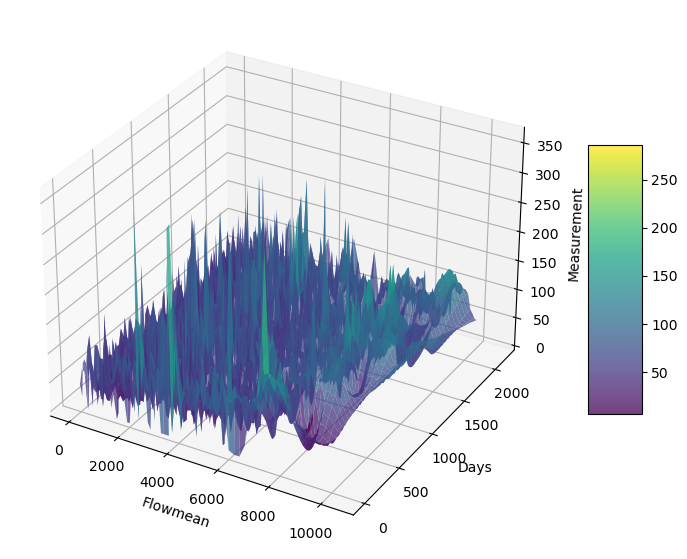

In [92]:

# 提取X, Y, Z
X = DataForNO['FlowMean']
Y = DataForNO['Hours']
Z = DataForNO['Measurement']

# 为了绘制曲面，我们需要创建一个网格
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# 使用griddata进行插值
zi = griddata((X, Y), Z, (xi, yi), method='cubic')
zi[zi < 0] = 0

# 创建图形和轴
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.75)

# 绘制数据点
#ax.scatter(X, Y, Z, color='red')

ax.set_xlabel('Flowmean')
ax.set_ylabel('Days')
ax.set_zlabel('Measurement')

# 添加颜色条
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

C:\Users\SBH\AppData\Local\Temp\ipykernel_34728\2815078286.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable, shrink=0.5, aspect=5)


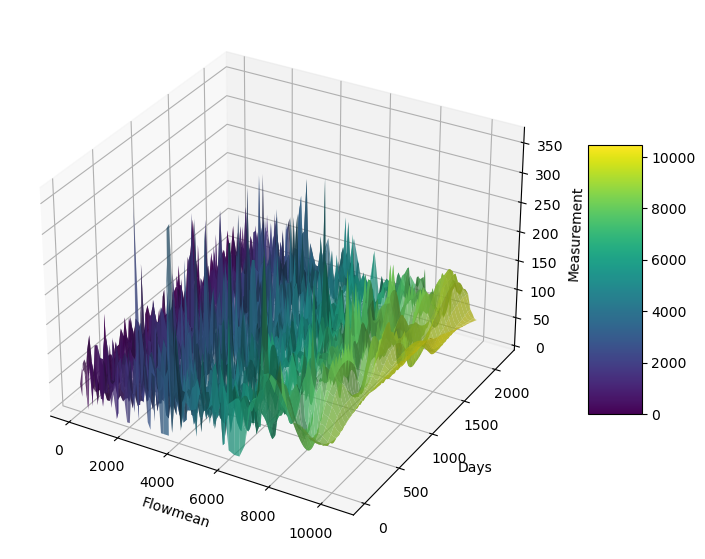

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.cm as cm

X = DataForNO['FlowMean']
Y = DataForNO['Hours']
Z = DataForNO['Measurement']
# 假设 X, Y, Z, xi, yi 已经根据你的数据计算得到
# zi = griddata((X, Y), Z, (xi, yi), method='cubic')
zi[zi < 0] = 0  # 确保没有负值

# 创建图形和轴
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 归一化X值用于颜色映射
X_normalized = (X - X.min()) / (X.max() - X.min())

# 根据归一化的X值选择颜色映射
colors = cm.viridis(X_normalized)

# 使用X值的归一化结果作为颜色映射绘制曲面
# 注意：这里我们使用ravel将xi, yi, zi变平，因为plot_surface需要2D数组作为输入
surf = ax.plot_surface(xi, yi, zi, facecolors=cm.viridis((xi - xi.min()) / (xi.max() - xi.min())), edgecolor='none', alpha=0.75)

# 设置轴标签
ax.set_xlabel('Flowmean')
ax.set_ylabel('Days')
ax.set_zlabel('Measurement')

# 添加颜色条
mappable = cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=X.min(), vmax=X.max()))
mappable.set_array([])
fig.colorbar(mappable, shrink=0.5, aspect=5)

plt.show()

In [28]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata


Y = DataForNO['FlowMean']
X = DataForNO['HourOfDay']
Z = DataForNO['Measurement']

xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((X, Y), Z, (xi, yi), method='cubic')
zi[zi < 0] = 0
"""

# 使用X和Y的网格坐标计算颜色映射
def calculate_color(x, y):
    return (x + y) / (x.max() + y.max())


color_values = calculate_color(xi, yi)

#only need to let surfacecolor=color_values

"""
fig = go.Figure(data=[go.Surface(z=zi, x=xi, y=yi, surfacecolor=xi)], 
                layout=go.Layout(
                    title='Correlation among NO2, FlowMean and Days',
                    autosize=False,
                    width=1250, height=600,
                    margin=dict(l=30, r=30, b=50, t=30)
                ))


fig.update_layout(scene=dict(
                    xaxis=dict(autorange='reversed', title='Time of Day'),
                    yaxis_title='FlowMean',
                    zaxis_title='NO2',
                    camera=dict(
                        up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=2, y=2, z=0.01)
                    )))

fig.show()